In [1]:
import numpy as np

full_data = np.load('./full_data.npy', allow_pickle=True)
X_train_event, X_test_event, X_train_obj, X_test_obj, y_train, y_test = full_data

In [2]:
import tensorflow as tf
from tensorflow import keras

combined_model = keras.models.load_model("./feb_11")
combined_model.summary()

2022-02-15 16:13:44.861447: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-15 16:13:48.255207: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-15 16:13:48.256085: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-15 16:13:48.826846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-02-15 16:13:48.826877: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-02-15 16:13:48.836822: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-0

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 14, 7)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 100)          43200       input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
layer_normalization_2 (LayerNor (None, 100)          200         lstm_2[0][0]                     
____________________________________________________________________________________________

In [3]:
# Model predictions
# with keras.backend.learning_phase_scope(1): 
#     y_probas = np.stack([combined_model.predict([X_test_obj, X_test_event]) for sample in range(100)]) 
#     y_pred = y_probas.mean(axis=0)


y_pred = combined_model.predict([X_test_obj, X_test_event])
y_train_pred = combined_model.predict([X_train_obj, X_train_event])

2022-02-15 16:13:57.236199: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-15 16:13:57.236619: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1996355000 Hz
2022-02-15 16:13:57.502910: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-02-15 16:13:57.688998: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [5]:
# ROC curve for test set

# y_pred = y_pred.reshape(y_pred.shape[0])

thresholds = np.arange(0, 1.001, 0.001)
FP = np.zeros(len(thresholds))
FN = np.zeros(len(thresholds))
TP = np.zeros(len(thresholds))
TN = np.zeros(len(thresholds))

test = y_test.values[:,-1]
for idx, threshold in enumerate(thresholds):
    # FP[idx] = ((y_test[y_test['ttH125'] == 0]) & (y_pred >= threshold)).sum()
    # FN[idx] = ((y_test[y_test['ttH125'] == 1]) & (y_pred < threshold)).sum()
    # TP[idx] = ((y_test[y_test['ttH125'] == 1]) & (y_pred >= threshold)).sum()
    # TN[idx] = ((y_test[y_test['ttH125'] == 0]) & (y_pred < threshold)).sum()
    # FP[idx] = len(y_test[(y_test['ttH125']==0) & (y_test['Predictions'] >= threshold)])
    # FN[idx] = len(y_test[(y_test['ttH125']==1) & (y_test['Predictions'] < threshold)])
    # TP[idx] = len(y_test[(y_test['ttH125']==1) & (y_test['Predictions'] >= threshold)])
    # TN[idx] = len(y_test[(y_test['ttH125']==0) & (y_test['Predictions'] < threshold)])
    FP[idx] = ((y_pred >= threshold) & (test==0)).sum()
    FN[idx] = ((y_pred < threshold) & (test==1)).sum()
    TP[idx] = ((y_pred >= threshold) & (test==1)).sum()
    TN[idx] = ((y_pred < threshold) & (test==0)).sum()





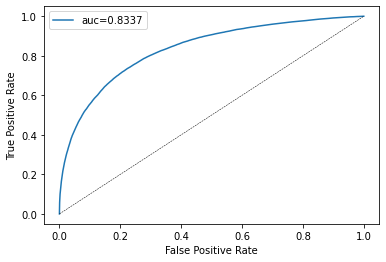

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(test, y_pred)

tpr = TP/(np.sum(test))
fpr = FP/(len(test) - np.sum(test))
plt.plot(fpr, tpr, label=f'auc={auc:.4f}')
plt.plot(np.arange(0, 1.0001, 0.0001), np.arange(0, 1.0001, 0.0001), linestyle='dashed', linewidth=0.5, color='k')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
# plt.savefig("./first_lstm_vs_lr_ROC.png", dpi=200)
plt.show()

In [9]:
f1 = TP/(TP+0.5*(FP+FN))
print(f"F1 score: {np.max(f1)} @ threshold of {thresholds[np.argmax(f1)]}")

F1 score: 0.6116206527305741 @ threshold of 0.5700000000000001


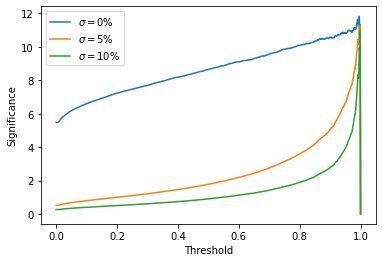

In [10]:
# Get weights
train_weights, test_weights = np.load('weights.npy', allow_pickle=True)

# Get significance on test set
significance_sigma0 = np.zeros(len(thresholds))
significance_sigma5 = np.zeros(len(thresholds))
significance_sigma10 = np.zeros(len(thresholds))

lum = 140e3
sg = np.zeros(len(thresholds))
bg = np.zeros(len(thresholds))
sigma = 0.1

for idx, threshold in enumerate(thresholds):
    sg[idx] = (lum * test_weights * 5 * ((y_pred >= threshold) & (test == 1)).astype(int)).sum()
    bg[idx] = (lum * test_weights * 5 * ((y_pred >= threshold) & (test == 0)).astype(int)).sum()
    if bg[idx] > 0:
        significance_sigma0[idx] = sg[idx]/np.sqrt(bg[idx])
        significance_sigma5[idx] = sg[idx]/np.sqrt(bg[idx] + (0.05 * bg[idx])**2)
        significance_sigma10[idx] = sg[idx]/np.sqrt(bg[idx] + (0.1 * bg[idx])**2)

plt.plot(thresholds, significance_sigma0, label=r"$\sigma=0\%$")
plt.plot(thresholds, significance_sigma5, label=r"$\sigma=5\%$")
plt.plot(thresholds, significance_sigma10, label=r"$\sigma=10\%$")
# plt.vlines(thresholds[np.argmax(significance)], linestyles="dashed", color='k', ymin=0, ymax=np.max(significance), linewidth=0.8,
#     label=f"Best threshold = {round(thresholds[np.argmax(significance[:end_idx])], 2)}")
# plt.hlines(np.max(significance), linestyles="dashed", color="k", xmin=0, xmax=1.0, linewidth=0.8)
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()

# plt.savefig("./first_lstm_significance_different_sigmas.png", dpi=200)
plt.legend()
plt.show()

Best threshold for sigma=0% is 0.996 
Best threshold for sigma=5% is 0.996 
Best threshold for sigma=10% is 0.999


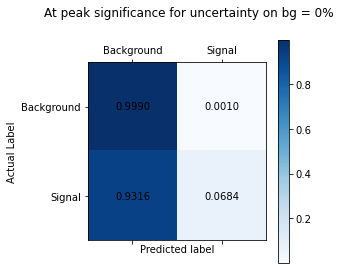

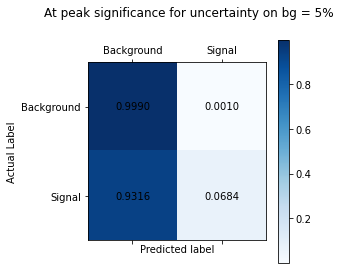

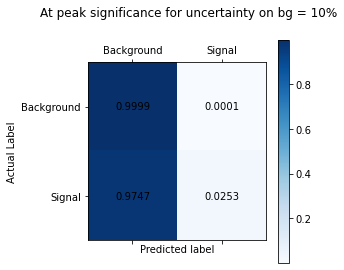

In [11]:
# Conf matrices @ peak sig

idx_0, idx_5, idx_10 = np.argmax(significance_sigma0), np.argmax(significance_sigma5), np.argmax(significance_sigma10)
print(f"Best threshold for sigma=0% is {thresholds[idx_0]} \nBest threshold for sigma=5% is {thresholds[idx_5]} \nBest threshold for sigma=10% is {thresholds[idx_10]}")
label = {0: 0, 1: 5, 2:10}
# idx_sig5 = np.argmin(abs(significance_sigma10-5))

for j, idx in enumerate((idx_0, idx_5, idx_10)):
    conf_mat = [[1-fpr[idx], fpr[idx]], [1-tpr[idx], tpr[idx]]]
    plt.matshow(conf_mat, cmap='Blues')
    for (x, y), value in np.ndenumerate(conf_mat):
        plt.text(y, x, f"{value:.4f}", va="center", ha="center")
    plt.xlabel('Predicted label')
    plt.ylabel('Actual Label')
    plt.xticks([0,1], labels=['Background', 'Signal'])
    plt.yticks([0,1], labels=['Background', 'Signal'])
    plt.colorbar()
    plt.suptitle(f"At peak significance for uncertainty on bg = {label[j]}%")
    # plt.savefig(f"./first_lstm_conf_mat_sigma_{label[j]}.png", dpi=200)
    plt.show()

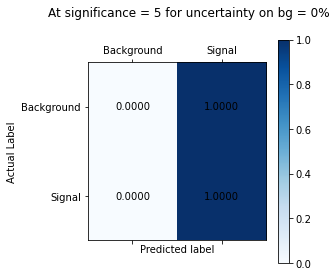

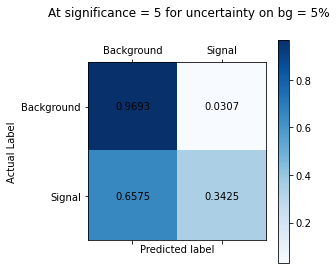

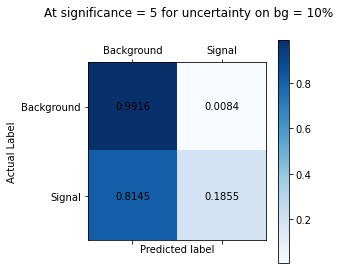

In [12]:
# conf matrices @ sig=5

idx_0, idx_5, idx_10 = np.argmin(abs(5-significance_sigma0)), np.argmin(abs(5-significance_sigma5[:idx_5])), np.argmin(abs(5-significance_sigma10[:idx_10]))
# print(f"Best threshold for sigma=0% is {thresholds[idx_0]} \nBest threshold for sigma=5% is {thresholds[idx_5]} \nBest threshold for sigma=10% is {thresholds[idx_10]}")
label = {0: 0, 1: 5, 2:10}
# idx_sig5 = np.argmin(abs(significance_sigma10-5))

for j, idx in enumerate((idx_0, idx_5, idx_10)):
    conf_mat = [[1-fpr[idx], fpr[idx]], [1-tpr[idx], tpr[idx]]]
    plt.matshow(conf_mat, cmap='Blues')
    for (x, y), value in np.ndenumerate(conf_mat):
        plt.text(y, x, f"{value:.4f}", va="center", ha="center")
    plt.xlabel('Predicted label')
    plt.ylabel('Actual Label')
    plt.xticks([0,1], labels=['Background', 'Signal'])
    plt.yticks([0,1], labels=['Background', 'Signal'])
    plt.colorbar()
    plt.suptitle(f"At significance = 5 for uncertainty on bg = {label[j]}%")
    # plt.savefig(f"./first_lstm_conf_mat_sigma_{label[j]}_sig_5.png", dpi=200)
    plt.show()

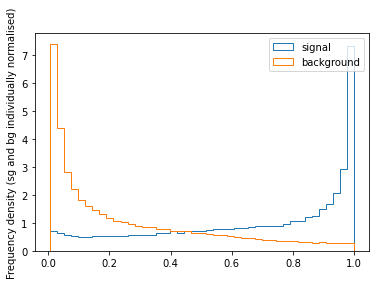

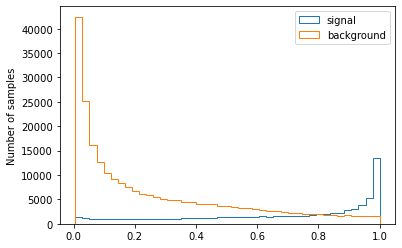

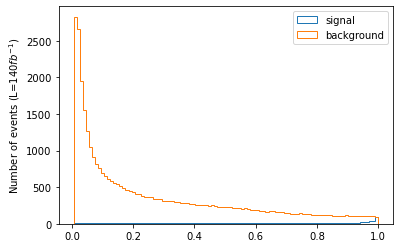

In [21]:
# Discriminator analysis on training set

hist_sg, bins, patches = plt.hist(y_train_pred[y_train.values[:,-1]==1], histtype='step', label="signal", density=True, bins='auto')
hist_bg, bins, patches = plt.hist(y_train_pred[y_train.values[:,-1]==0], histtype='step', label="background", density=True, bins=bins)
plt.ylabel("Frequency density (sg and bg individually normalised)")
plt.legend()
plt.show()

hist_sg_counts, bins_counts, patches = plt.hist(y_train_pred[y_train.values[:,-1]==1], histtype='step', label="signal", bins='auto')
hist_bg_counts, bins_counts, patches = plt.hist(y_train_pred[y_train.values[:,-1]==0], histtype='step', label="background", bins=bins_counts)
plt.ylabel("Number of samples")
plt.legend()
plt.show()

hist_sg_xs, bins_xs, patches = plt.hist(y_train_pred[y_train.values[:,-1]==1], histtype='step', label="signal", weights=140e3*train_weights[y_train.values[:,-1]==1], bins=100)
hist_bg_xs, bins_xs, patches = plt.hist(y_train_pred[y_train.values[:,-1]==0], histtype='step', label="background", weights=140e3*train_weights[y_train.values[:,-1]==0], bins=bins_xs)
plt.ylabel(r"Number of events (L=$140fb^{-1}$)")
plt.legend()
plt.show()

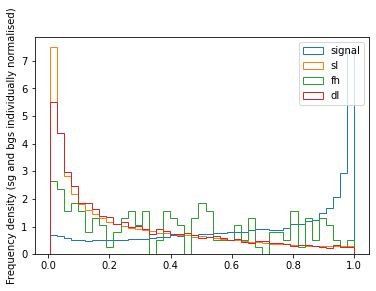

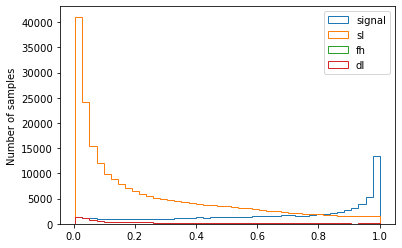

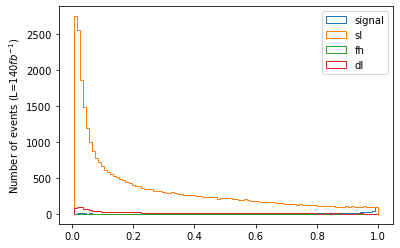

In [22]:
# Individual background analysis

hist_sg, bins, patches = plt.hist(y_train_pred[y_train.values[:,-1]==1], histtype='step', label="signal", density=True, bins='auto')
hist_sl, bins, patches = plt.hist(y_train_pred[y_train.values[:,-2]==1], histtype='step', label="sl", density=True, bins=bins)
hist_fh, bins, patches = plt.hist(y_train_pred[y_train.values[:,-3]==1], histtype='step', label="fh", density=True, bins=bins)
hist_dl, bins, patches = plt.hist(y_train_pred[y_train.values[:,0]==1], histtype='step', label="dl", density=True, bins=bins)

plt.ylabel("Frequency density (sg and bgs individually normalised)")
plt.legend()
plt.show()

hist_sg_counts, bins_counts, patches = plt.hist(y_train_pred[y_train.values[:,-1]==1], histtype='step', label="signal", bins='auto')
hist_sl_counts, bins_counts, patches = plt.hist(y_train_pred[y_train.values[:,-2]==1], histtype='step', label="sl", bins=bins_counts)
hist_fh_counts, bins_counts, patches = plt.hist(y_train_pred[y_train.values[:,-3]==1], histtype='step', label="fh", bins=bins_counts)
hist_dl_counts, bins_counts, patches = plt.hist(y_train_pred[y_train.values[:,0]==1], histtype='step', label="dl", bins=bins_counts)
plt.ylabel("Number of samples")
plt.legend()
plt.show()

hist_sg_xs, bins_xs, patches = plt.hist(y_train_pred[y_train.values[:,-1]==1], histtype='step', label="signal", weights=140e3*train_weights[y_train.values[:,-1]==1], bins=100)
hist_sl_xs, bins_xs, patches = plt.hist(y_train_pred[y_train.values[:,-2]==1], histtype='step', label="sl", weights=140e3*train_weights[y_train.values[:,-2]==1], bins=bins_xs)
hist_fh_xs, bins_xs, patches = plt.hist(y_train_pred[y_train.values[:,-3]==1], histtype='step', label="fh", weights=140e3*train_weights[y_train.values[:,-3]==1], bins=bins_xs)
hist_dl_xs, bins_xs, patches = plt.hist(y_train_pred[y_train.values[:,0]==1], histtype='step', label="dl", weights=140e3*train_weights[y_train.values[:,0]==1], bins=bins_xs)
plt.ylabel(r"Number of events (L=$140fb^{-1}$)")
plt.legend()
plt.show()

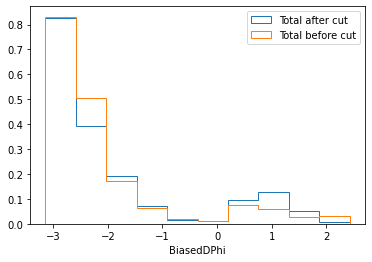

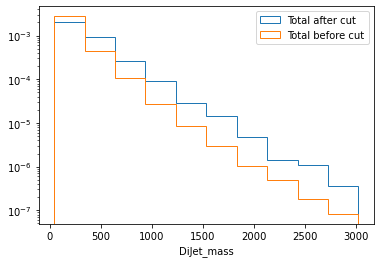

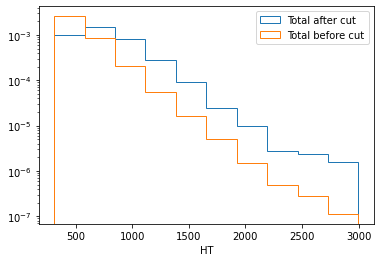

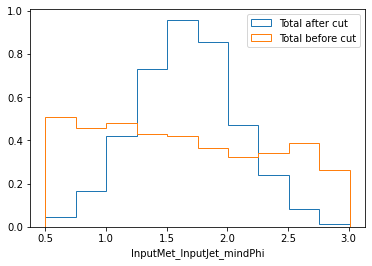

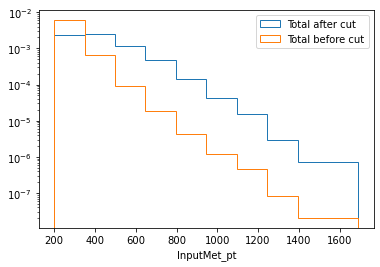

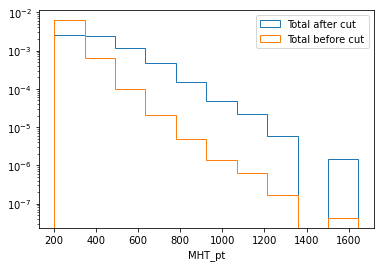

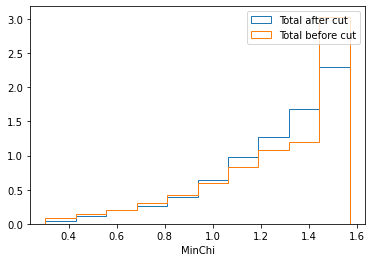

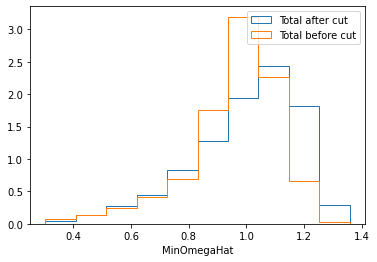

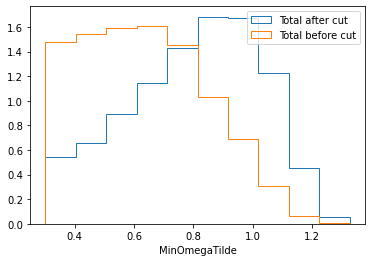

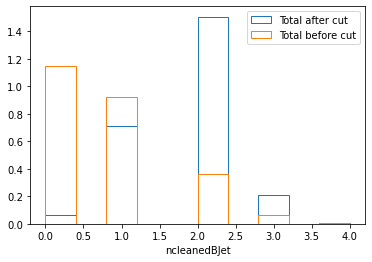

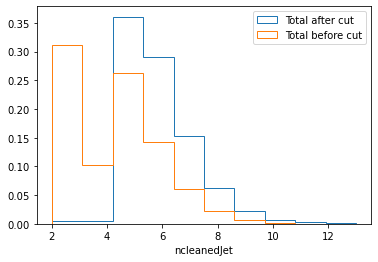

In [36]:
import pandas as pd

X_train_df = pd.read_hdf("X_train_combined.hd5")
X_train_df_event = X_train_df.select_dtypes(exclude=object).values

columns = ['BiasedDPhi', 'DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_pt', 'MHT_pt', 'MinChi', 'MinOmegaHat', 'MinOmegaTilde',
       'ncleanedBJet', 'ncleanedJet']
y_train_pred = y_train_pred.reshape(y_train_pred.shape[0])
thresh = 0.99
for idx, column in enumerate(columns):
       if column in ('HT', 'InputMet_pt', 'MHT_pt', 'DiJet_mass'):
              log = True
       else:
              log = False
       hist, bins, patches = plt.hist(X_train_df_event[y_train_pred >= thresh][:, idx], label=f'Total after cut', log=log, histtype="step", density=True)
       plt.hist(X_train_df_event[:, idx], label=f'Total before cut', log=log, histtype="step", bins=bins, density=True)
       # plt.hist(X_test_df_event[(y_pred >= thresh) & (test==1)][:, idx], label=f"true positives", log=log, density=True, histtype="step", bins=bins)
       # plt.hist(X_test_df_event[(y_pred >= thresh) & (test==0)][:, idx], label=f"false positives", log=log, density=True, histtype="step", bins=bins)
       plt.xlabel(column)
       plt.legend()
       plt.show()


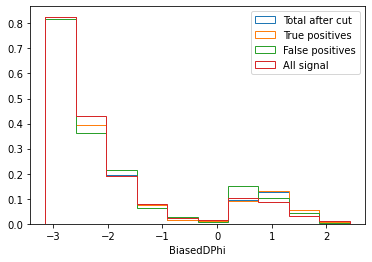

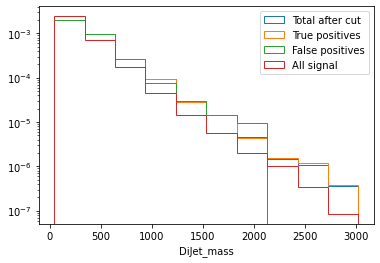

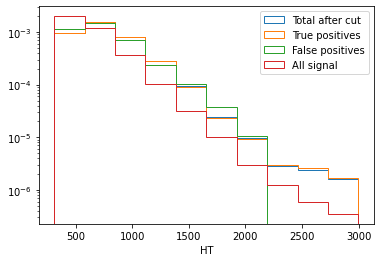

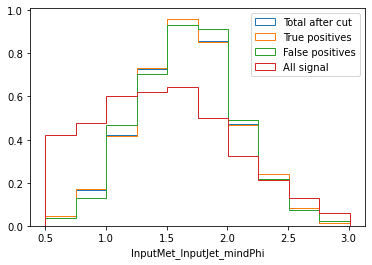

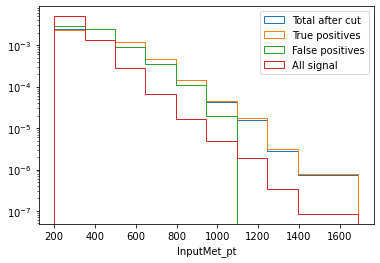

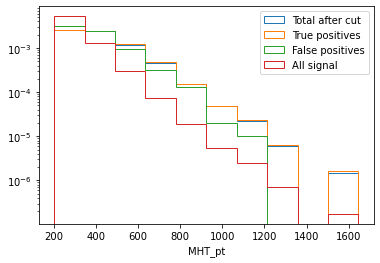

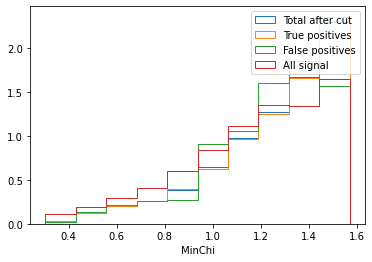

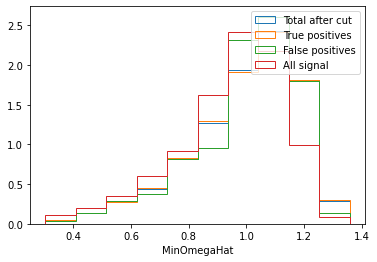

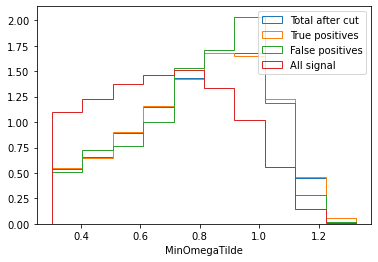

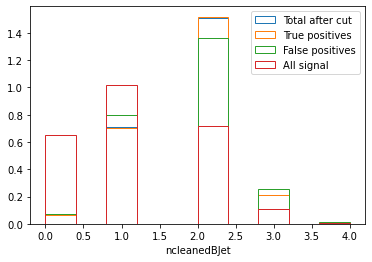

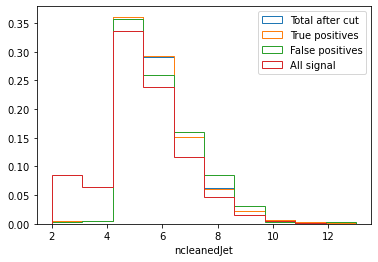

In [38]:
for idx, column in enumerate(columns):
       if column in ('HT', 'InputMet_pt', 'MHT_pt', 'DiJet_mass'):
              log = True
       else:
              log = False
       hist, bins, patches = plt.hist(X_train_df_event[y_train_pred >= thresh][:, idx], label=f'Total after cut', log=log, histtype="step", density=True)
       plt.hist(X_train_df_event[(y_train_pred >= thresh) & (y_train.values[:,-1]==1)][:, idx], label=f'True positives', log=log, histtype="step", bins=bins, density=True)
       plt.hist(X_train_df_event[(y_train_pred >= thresh) & (y_train.values[:,-1]==0)][:, idx], label=f'False positives', log=log, histtype="step", bins=bins, density=True)
       plt.hist(X_train_df_event[y_train.values[:,-1]==1][:, idx], label=f'All signal', log=log, histtype="step", bins=bins, density=True)
       # plt.hist(X_test_df_event[(y_pred >= thresh) & (test==1)][:, idx], label=f"true positives", log=log, density=True, histtype="step", bins=bins)
       # plt.hist(X_test_df_event[(y_pred >= thresh) & (test==0)][:, idx], label=f"false positives", log=log, density=True, histtype="step", bins=bins)
       plt.xlabel(column)
       plt.legend()
       plt.show()